In [2]:
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset
file_path = 'data/MacroKAGCN.csv'
dataset = pd.read_csv(file_path)

In [3]:
# Select relevant features
features = [
    'Net trade in goods and services (BoP, current US$)',
    'GDP (current US$)',
    'Consumer price index (2010 = 100)',
    'Unemployment, total (% of total labor force) (national estimate)',
    'Exports of goods and services (BoP, current US$)',
    'Imports of goods and services (BoP, current US$)',
    'Foreign direct investment, net (BoP, current US$)'
]

# Drop rows with missing values for simplicity
cleaned_dataset = dataset.dropna(subset=features + ['Official exchange rate (LCU per US$, period average)'])


# Normalize the features
scaler = StandardScaler()
cleaned_dataset[features] = scaler.fit_transform(cleaned_dataset[features])

# Extract unique countries and years
selected_countries = cleaned_dataset['Country Code'].unique()[:6]
years = cleaned_dataset['Year'].str.extract(r'(\d+)').astype(int)[0].unique()
years.sort()

# Initialize the graph
G = nx.Graph()

In [130]:
# Example function to compute weighted exchange rates
def weighted_exchange_rate(exchange_rates, alpha=1.5):
    
    # Apply an exponential decay to weigh more recent rates more heavily
    weights = np.array([alpha ** i for i in range(len(exchange_rates))])
    weights = weights / weights.sum()  # Normalize weights
    weighted_avg = np.dot(exchange_rates, weights)
    return weighted_avg

In [131]:
# Adding nodes for each country and connecting them fully for each year
for year in years:
    previous_nodes = []
    for country in selected_countries:
        node_id = f"{country}_{year}"
        node_features = cleaned_dataset[
            (cleaned_dataset['Country Code'] == country) &
            (cleaned_dataset['Year'].str.contains(str(year)))
        ][features].values[0]
        
        # Calculate the weighted exchange rate
        exchange_rates = [G.nodes[f"{country}_{prev_year}"]['exchange_rate'] for prev_year in years if prev_year <= year]
        weighted_rate = weighted_exchange_rate(exchange_rates[-4:])
        
        # Add the weighted exchange rate as a new feature
        node_features_with_weighted_rate = np.append(node_features, weighted_rate)
        
        G.add_node(node_id, features=node_features_with_weighted_rate)
        previous_nodes.append(node_id)

    # Add edges between every pair of nodes within the same year (complete graph for each year)
    for i in range(len(previous_nodes)):
        for j in range(i + 1, len(previous_nodes)):
            G.add_edge(previous_nodes[i], previous_nodes[j], weight=1)

In [132]:
# Prepare the dataset for PyTorch Geometric
def create_pyg_data(G):
    data_list = []
    for year in years:
        
        x = []
        edge_index = []
        y = []

        for i, country in enumerate(selected_countries):
            node_id = f"{country}_{year}"
            x.append(G.nodes[node_id]['features'])
            y.append(G.nodes[node_id]['exchange_rate'])

            for j in range(len(selected_countries)):
                if i != j:
                    target_node = f"{selected_countries[j]}_{year}"
                    edge_index.append([i, j])

        x = torch.tensor(x, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        y = torch.tensor(y, dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    return data_list

data_list = create_pyg_data(G)
loader = DataLoader(data_list, batch_size=1, shuffle=False)

In [138]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class TemporalAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(TemporalAttentionLayer, self).__init__()
        self.W = nn.Parameter(torch.Tensor(in_features, out_features))
        self.attn_fc = nn.Linear(out_features, 1)

        nn.init.xavier_uniform_(self.W)

    def forward(self, x, edge_index):
        h = torch.matmul(x, self.W)
        attn_scores = F.leaky_relu(self.attn_fc(h))
        attn_scores = F.softmax(attn_scores, dim=0)
        
        # Attention-weighted sum of features
        h = h * attn_scores
        return h
    
class AdvancedKAGCN(nn.Module):
    def __init__(self, num_node_features, num_output_features):
        super(AdvancedKAGCN, self).__init__()
        self.conv1 = GCNConv(in_channels=num_node_features, out_channels=16)
        self.attention = TemporalAttentionLayer(in_features=16, out_features=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=16)
        
        # Fully connected layers - adjust the input size here
        self.fc1 = nn.Linear(in_features=16, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=num_output_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        
        # Apply temporal attention
        x = self.attention(x, edge_index)
        
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Pooling over all nodes in the graph

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x



In [148]:
# Training and evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdvancedKAGCN(num_node_features=8, num_output_features=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    total_loss = 0
    decay_factor = 0.96  # Decay factor for older years

    for i, data in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        
        # Apply decay to weight recent years more heavily
        weighted_loss = loss * (decay_factor ** (len(loader) - i))
        weighted_loss.backward()
        optimizer.step()
        
        total_loss += weighted_loss.item()
    
    return total_loss / len(loader)


In [149]:
def evaluate():
    model.eval()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            # Add evaluation metrics here, such as MSE, MAE, etc.

In [150]:
# Training loop
for epoch in range(1000):  # Example: 500 epochs
    loss = train()
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# After training, run evaluation
evaluate()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 39164.2991
Epoch 2, Loss: 38918.3538
Epoch 3, Loss: 38270.2638
Epoch 4, Loss: 36447.5844
Epoch 5, Loss: 31565.9416
Epoch 6, Loss: 21746.4709
Epoch 7, Loss: 8975.9044
Epoch 8, Loss: 2549.8569
Epoch 9, Loss: 2175.5316
Epoch 10, Loss: 2181.7313
Epoch 11, Loss: 2163.7924
Epoch 12, Loss: 2163.8030
Epoch 13, Loss: 2164.3615
Epoch 14, Loss: 2162.5955
Epoch 15, Loss: 2162.2402
Epoch 16, Loss: 2162.0152
Epoch 17, Loss: 2161.8679
Epoch 18, Loss: 2161.8193
Epoch 19, Loss: 2161.8954
Epoch 20, Loss: 2162.1750
Epoch 21, Loss: 2163.3418
Epoch 22, Loss: 2163.0448
Epoch 23, Loss: 2164.6422
Epoch 24, Loss: 2164.9715
Epoch 25, Loss: 2165.5755
Epoch 26, Loss: 2160.4502
Epoch 27, Loss: 2159.8109
Epoch 28, Loss: 2165.8706
Epoch 29, Loss: 2164.8760
Epoch 30, Loss: 2164.2425
Epoch 31, Loss: 2161.8044
Epoch 32, Loss: 2159.9608
Epoch 33, Loss: 2158.4045
Epoch 34, Loss: 2157.2503
Epoch 35, Loss: 2156.4082
Epoch 36, Loss: 2167.4800
Epoch 37, Loss: 2153.9364
Epoch 38, Loss: 2156.2992
Epoch 39, Loss:

In [151]:
def predict(model, data):
    model.eval()  # Set the model to evaluation mode
    data = data.to(device)  # Move data to the correct device (GPU or CPU)
    
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(data)  # Forward pass through the model
        predictions = output.cpu().numpy()  # Convert predictions to numpy array (if needed)
    
    return predictions

# Example usage:
# Assuming `new_data` is a Data object for the year you want to predict
# Load your new data following the same structure as the training data

# Use the model to predict the exchange rates for the next year
for data in loader:
    predictions = predict(model, data)
print("Predicted exchange rates for the next year:", predictions)

Predicted exchange rates for the next year: [[1.0070978  0.7422581  1.35517    0.97579026 0.9451766  0.96808755]]


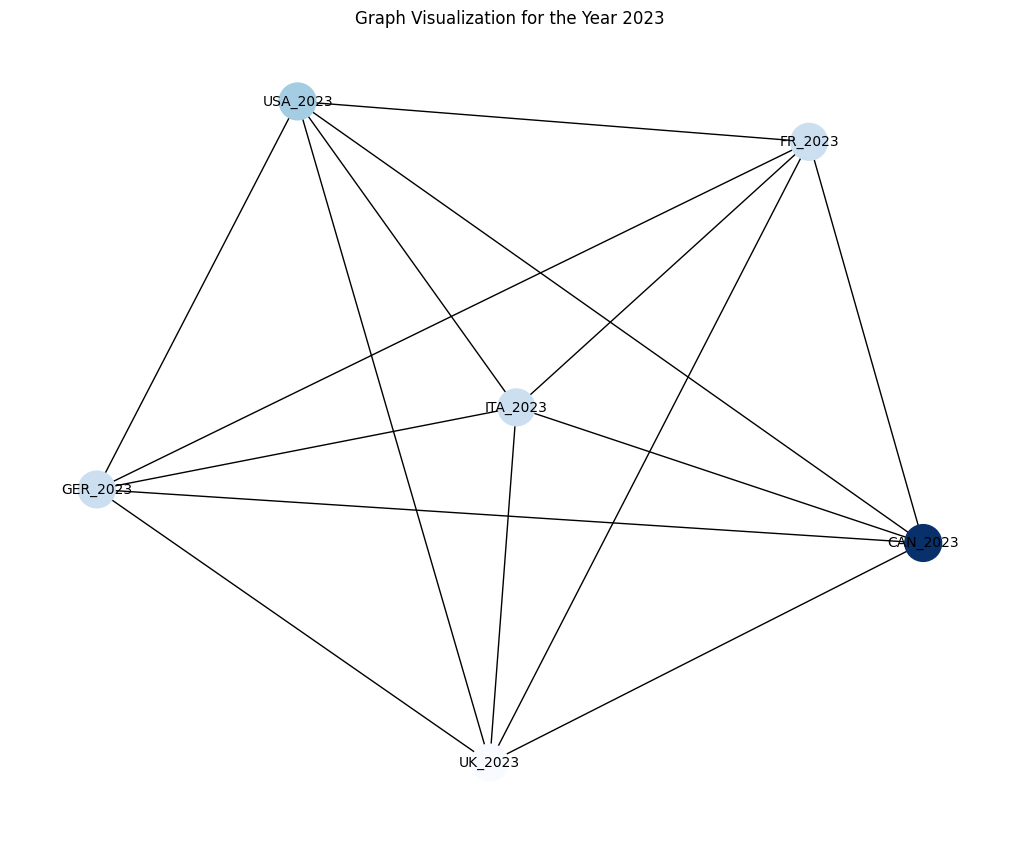

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_graph(G, year):
    # Filter nodes to display only those for the specified year
    nodes_to_display = [node for node in G.nodes if node.endswith(f"_{year}")]
    
    # Create a subgraph for the specified year
    subgraph = G.subgraph(nodes_to_display)
    
    # Extract exchange rates for coloring
    exchange_rates = nx.get_node_attributes(subgraph, 'exchange_rate')
    
    # Define the node color map based on exchange rates
    node_colors = [exchange_rates[node] for node in subgraph.nodes]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)  # Positioning the nodes
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Blues, node_size=700, font_size=10)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    plt.title(f"Graph Visualization for the Year {year}")
    plt.show()

# Example usage
year_to_visualize = 2023  # Replace with the year you want to visualize
visualize_graph(G, year_to_visualize)